In [1]:
import sys
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(str(Path().resolve().parent))

In [2]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoImageProcessor, ViTMAEModel

SEED = 33
random.seed(SEED)

The images in this subset were captured at the ideal focal plane and are generally well-focused, providing a reliable foundation for analyzing embedding behavior. While some variation in illumination and cellular morphology remains, this reflects the inherent complexity of real microscopy data. Rather than artificially standardizing the inputs, we embrace this variability to assess how it influences embedding structure, robustness, and semantic similarity.

In [3]:
def load_and_normalize(path):
    # Load image as 16-bit grayscale
    img = Image.open(path)
    img_array = np.array(img).astype(np.float32)

    # Normalize to 0–255 range for display or RGB conversion
    img_array -= img_array.min()
    img_array /= img_array.max()
    img_array *= 255.0

    # Convert to 8-bit and RGB
    img_uint8 = img_array.astype(np.uint8)
    img_rgb = Image.fromarray(img_uint8).convert("RGB")

    return img_rgb

In [4]:
image_paths = sorted(glob.glob("../examples/bbbc_subset/*.tif"))
images = [load_and_normalize(p) for p in image_paths]

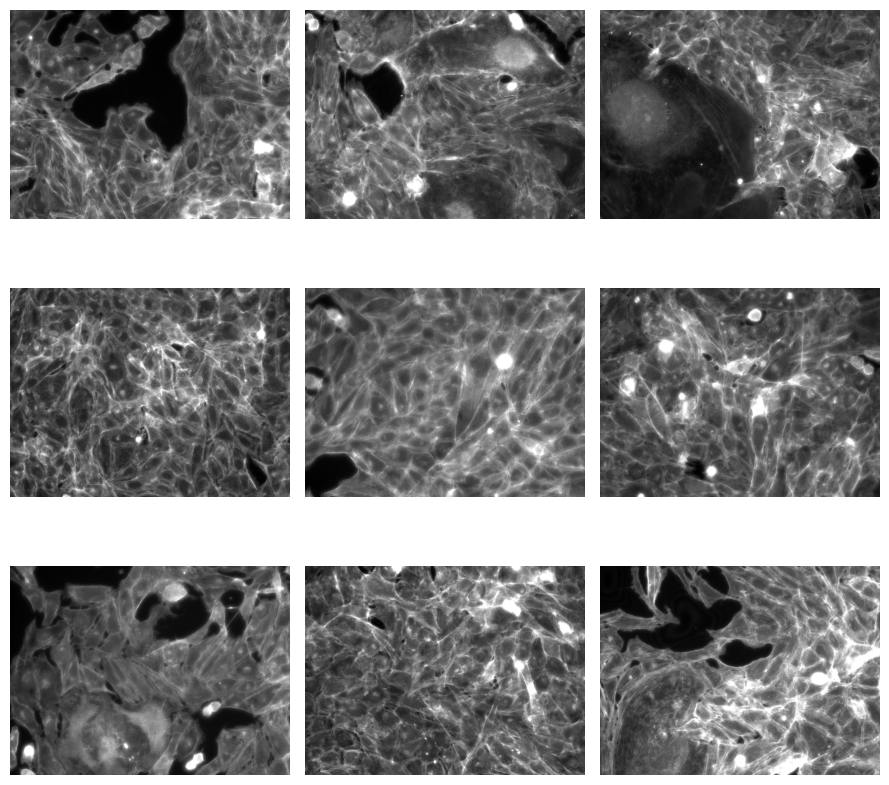

In [5]:
sample = random.sample(images, 9)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(sample[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

We embed the normalized microscopy images using a pretrained Masked Autoencoder (MAE) model from Facebook AI (facebook/vit-mae-base). The model outputs patch-level embeddings without a [CLS] token, so we apply mean pooling across all patch representations to obtain a single vector per image. This compact embedding captures high-level visual features and serves as the basis for analyzing semantic structure and robustness in the presence of biological noise.

In [6]:
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/vit-mae-base", use_fast=True
)
model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
model.eval()

ViTMAEModel(
  (embeddings): ViTMAEEmbeddings(
    (patch_embeddings): ViTMAEPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (encoder): ViTMAEEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTMAELayer(
        (attention): ViTMAEAttention(
          (attention): ViTMAESelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTMAESelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTMAEIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTMAEOutput(
          (dense): Linear(i

In [7]:
embeddings = []
for img in images:
    with torch.no_grad():
        inputs = image_processor(images=img, return_tensors="pt")
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.squeeze(0).mean(dim=0).numpy()
    embeddings.append(embedding)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)

Embedding matrix shape: (20, 768)


We compute the pairwise cosine similarity between all image embeddings. Brighter squares indicate higher similarity. Without ground-truth labels, this serves as a proxy to assess clustering, outliers, and the model's sensitivity to input variation.

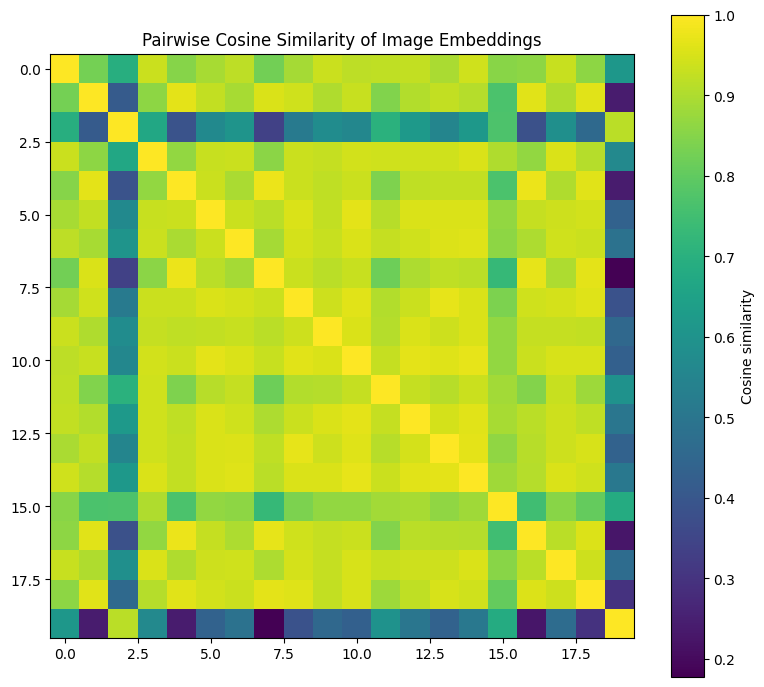

In [8]:
# Compute similarity
sim_matrix = cosine_similarity(embeddings)

# Extract short file names (without path)
labels = [os.path.basename(p) for p in image_paths]

# Plot
plt.figure(figsize=(8, 7))
plt.imshow(sim_matrix, cmap="viridis")
plt.colorbar(label="Cosine similarity")
plt.title("Pairwise Cosine Similarity of Image Embeddings")


plt.tight_layout()
plt.show()

We project the high-dimensional MAE embeddings into 2D using t-SNE to examine whether input variation (e.g., biological diversity, blur) is reflected in the embedding space. This offers a visual proxy for clustering and potential semantic separation, even without labels.

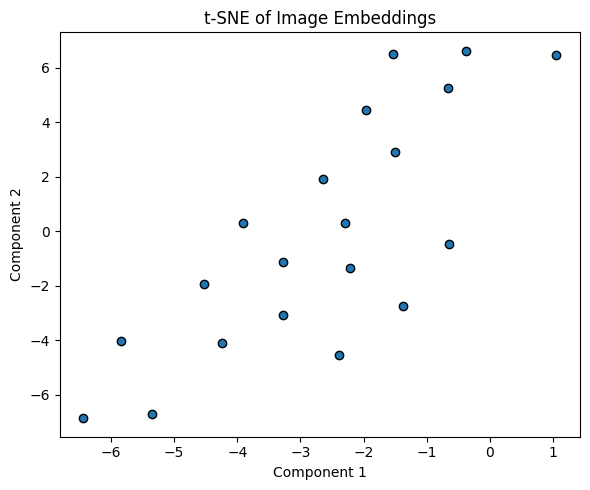

In [9]:
import matplotlib.pyplot as plt

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=SEED)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], edgecolor="k")
plt.title("t-SNE of Image Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

To evaluate embedding robustness, we apply Gaussian noise of varying intensity to input images and compare the resulting embeddings to their clean counterparts. We observe that even small input perturbations induce measurable drift in embedding space, revealing how MAE representations respond to subtle visual changes — an important factor in model validation and downstream retrieval reliability.

In [10]:
def add_gaussian_noise(inputs, std=0.05):
    noisy_inputs = inputs.copy()
    tensor = inputs["pixel_values"]
    noise = torch.randn_like(tensor) * std
    noisy_inputs["pixel_values"] = torch.clip(tensor + noise, 0, 1)
    return noisy_inputs

In [11]:
drift_values = []
std_levels = [0.01, 0.05, 0.1, 0.2]

for std in std_levels:
    drifts = []
    for img in images:
        inputs = image_processor(images=img, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            emb_original = outputs.last_hidden_state.squeeze(0).mean(dim=0).numpy()

        noisy_inputs = add_gaussian_noise(inputs, std=std)
        with torch.no_grad():
            outputs = model(**inputs)
            emb_noisy = outputs.last_hidden_state.squeeze(0).mean(dim=0).numpy()

        drift = np.linalg.norm(emb_original - emb_noisy)
        drifts.append(drift)
    drift_values.append(np.mean(drifts))

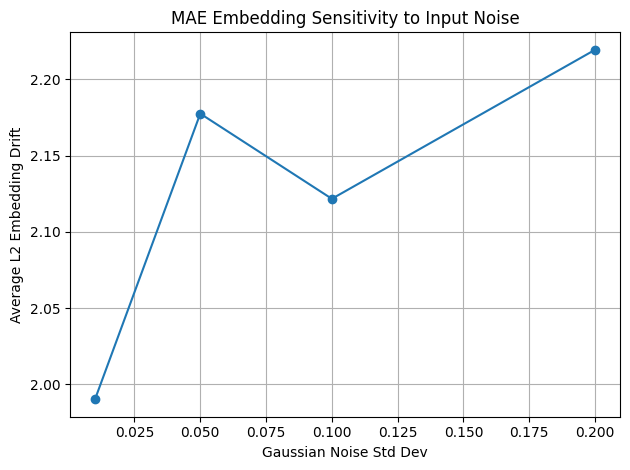

In [12]:
plt.plot(std_levels, drift_values, marker="o")
plt.xlabel("Gaussian Noise Std Dev")
plt.ylabel("Average L2 Embedding Drift")
plt.title("MAE Embedding Sensitivity to Input Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

We visualize pairs of original and noise-perturbed images to qualitatively assess input degradation. By embedding both and projecting via t-SNE, we observe how image-level noise affects spatial relationships in embedding space. Connecting each clean-noisy pair shows the embedding drift directly.

In [13]:
embeddings_combined = []
labels = []
std = 0.1

for i, img in enumerate(images[:10]):  # Use 10 image pairs for clarity
    # Process original
    inputs = image_processor(img, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    emb_clean = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings_combined.append(emb_clean)
    labels.append(f"clean_{i}")

    # Process noisy version
    noisy_inputs = add_gaussian_noise(inputs.copy(), std=std)
    with torch.no_grad():
        output = model(**noisy_inputs)
    emb_noisy = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings_combined.append(emb_noisy)
    labels.append(f"noisy_{i}")

In [14]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=10)
emb_2d = tsne.fit_transform(np.array(embeddings_combined))

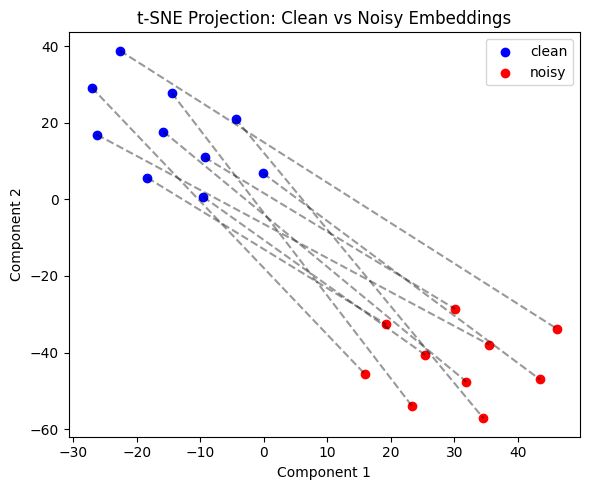

In [15]:
plt.figure(figsize=(6, 5))

for i in range(0, len(labels), 2):
    x_clean, y_clean = emb_2d[i]
    x_noisy, y_noisy = emb_2d[i + 1]

    # Connect each pair with a line
    plt.plot([x_clean, x_noisy], [y_clean, y_noisy], "k--", alpha=0.4)

    # Plot clean and noisy points
    plt.scatter(x_clean, y_clean, color="blue", label="clean" if i == 0 else "")
    plt.scatter(x_noisy, y_noisy, color="red", label="noisy" if i == 0 else "")

plt.title("t-SNE Projection: Clean vs Noisy Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we explored the behavior of pretrained Masked Autoencoder (MAE) embeddings on real microscopy images using a subset of BBBC006. We began by normalizing and inspecting the raw data, highlighting issues such as blur and illumination variability common in biological imaging.

Using a ViT-MAE model from Hugging Face, we extracted patch-based embeddings and pooled them to obtain compact representations of each image. We visualized these embeddings with cosine similarity and t-SNE, revealing a variety of structures even in the absence of ground-truth labels.

To probe robustness, we applied Gaussian noise to the input images and analyzed how much the resulting embeddings shifted. Both quantitative (L2 drift) and visual (t-SNE) analyses showed that even small input perturbations can significantly affect the embedding space — a key consideration for downstream tasks like retrieval, classification, and validation in regulated domains.

## Next Steps

- Benchmarking across pretrained transformer-based vision models (e.g., ViT, MAE variants)
- Evaluating robustness to input perturbations (blur, brightness shifts, cropping)
- Analyzing embedding drift under biological and technical variability
- Integrating similarity search with FAISS for prototype semantic retrieval
- Exploring t-SNE and clustering behavior across deeper z-stacks and other imaging modalities
- Investigating patch-wise attribution or interpretability tools for embedding diagnostics